In [1]:
import json

In [2]:
with open('../results/short.json', 'r') as f:
    short = json.load(f)
with open('../results/long.json', 'r') as f:
    long = json.load(f)
with open('../results/medium.json', 'r') as f:
    medium = json.load(f)

# 推理步骤

In [3]:
short_steps = [len(x.split("\n")) // 10 for x in short]
medium_steps = [len(x.split("\n")) // 10 for x in medium]
long_steps = [len(x.split("\n")) // 10 for x in long]

max_steps = max(max(short_steps), max(medium_steps), max(long_steps))
max_steps

17

In [4]:
steps = [[0] * (max_steps + 1) for i in range(3)]

for i, x in enumerate(short_steps):
    steps[0][x] += 1

for i, x in enumerate(medium_steps):
    steps[1][x] += 1

for i, x in enumerate(long_steps):
    steps[2][x] += 1
steps

[[0, 58, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 13, 10, 2],
 [0, 29, 21, 8, 5, 4, 5, 0, 4, 1, 0, 0, 0, 0, 4, 12, 7, 0],
 [0, 1, 18, 24, 5, 1, 0, 0, 1, 0, 0, 0, 0, 11, 12, 19, 8, 0]]

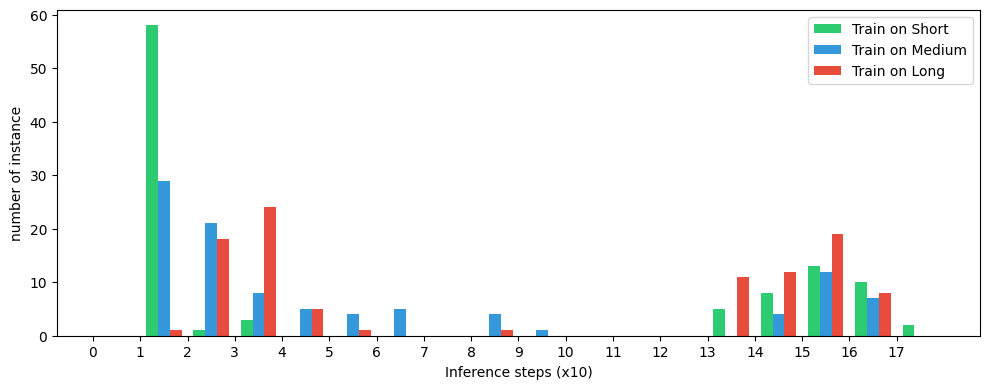

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def plot_grouped_bars(data, labels=None, colors=None, width=0.25, x_label=""):
    """
    绘制分组柱状图
    
    参数:
    - data: shape为(3,x)的numpy数组
    - labels: 三组数据的标签
    - colors: 三组数据的颜色
    - width: 柱子的宽度
    """
    if labels is None:
        labels = [f'Group {i + 1}' for i in range(3)]
    if colors is None:
        colors = ['#2ecc71', '#3498db', '#e74c3c']

    n_groups = data.shape[1]
    x = np.arange(n_groups)

    fig, ax = plt.subplots(figsize=(10, 4))

    # 绘制三组柱子
    rects1 = ax.bar(x - width + 0.5, data[0], width, label=labels[0], color=colors[0])
    rects2 = ax.bar(x + 0.5, data[1], width, label=labels[1], color=colors[1])
    rects3 = ax.bar(x + width + 0.5, data[2], width, label=labels[2], color=colors[2])

    # 添加标签和标题
    ax.set_ylabel('number of instance')
    ax.set_xlabel(x_label)
    # ax.set_title('Grouped Bar Chart')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i}' for i in range(n_groups)])
    ax.legend()

    # 调整布局
    plt.tight_layout()

    return fig


labels = ['Train on Short', 'Train on Medium', 'Train on Long']
colors = ['#2ecc71', '#3498db', '#e74c3c']

fig = plot_grouped_bars(np.array(steps), labels, colors, x_label='Inference steps (x10)')
plt.savefig('./fig/inference_steps_of_result.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Token 长度统计

In [6]:
from transformers import AutoTokenizer

In [7]:
model_name = "d:/model/Qwen/Qwen2___5-0___5B-Instruct/"
# model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
short_token_length = [len(tokenizer.encode(x)) // 200 for x in short]
medium_token_length = [len(tokenizer.encode(x)) // 200 for x in medium]
long_token_length = [len(tokenizer.encode(x)) // 200 for x in long]

max_token_length = max(max(short_token_length), max(medium_token_length), max(long_token_length))
max_token_length

21

In [9]:
lengths = [[0] * (max_token_length + 1) for i in range(3)]

for i, x in enumerate(short_token_length):
    lengths[0][x] += 1

for i, x in enumerate(medium_token_length):
    lengths[1][x] += 1

for i, x in enumerate(long_token_length):
    lengths[2][x] += 1
lengths

[[0, 57, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38],
 [0, 10, 33, 8, 7, 4, 4, 2, 3, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 23],
 [0, 1, 0, 18, 21, 5, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50]]

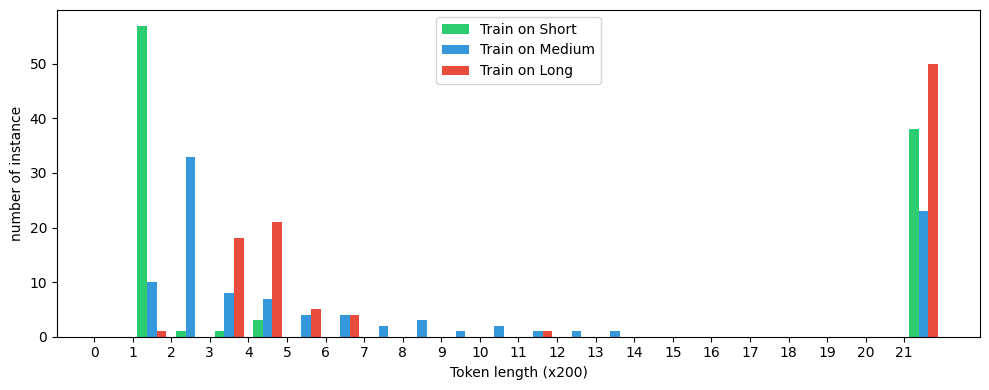

In [10]:
fig = plot_grouped_bars(np.array(lengths), labels, colors, x_label='Token length (x200)')
plt.savefig('./fig/token_length_of_result.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Accuracy

In [11]:
with open("../dataset/test_cases.json", "r") as f:
    test_cases = json.load(f)

In [12]:
def extract_numbers(expr) -> list:
    curr_num = ''
    numbers = []
    for c in expr:
        if c.isdigit():
            curr_num += c
        elif curr_num:
            numbers.append(int(curr_num))
            curr_num = ''
    if curr_num:
        numbers.append(int(curr_num))
    return numbers

In [13]:
def evaluate_result(results):
    correct = 0
    error = 0
    unreach = 0
    for result in results:
        lines = result.split('\n')
        last_line = lines[-1]
        if "expression:" not in last_line:
            unreach += 1
            continue
        expression = last_line.split('expression:')[-1]
        nums = extract_numbers(expression)
        if not test_cases[i].sort() == nums.sort():
            # 数字不匹配
            error += 1
            continue

        try:
            value = eval(expression)
            if abs(value - 24) < 1e-6:
                correct += 1
            else:
                # 计算结果不对
                error += 1
        except Exception as e:
            error += 1
    return correct / len(results), error / len(results), unreach / len(results)


In [14]:
short_metric = evaluate_result(short)

In [15]:
medium_metric = evaluate_result(medium)

In [16]:
long_metric = evaluate_result(long)

In [17]:
short_metric, medium_metric, long_metric

((0.57, 0.05, 0.38), (0.72, 0.05, 0.23), (0.5, 0.0, 0.5))

In [18]:
def plot_multi_lines(data, labels=None, colors=None, markers=None, styles=None, x=None):
    """
    绘制三根折线的折线图
    
    参数:
    - data: shape为(3,x)的numpy数组
    - labels: 三条线的标签
    - colors: 三条线的颜色
    - markers: 三条线的标记样式
    - styles: 三条线的线型
    """
    if labels is None:
        labels = [f'Line {i + 1}' for i in range(3)]
    if colors is None:
        colors = ['#2ecc71', '#3498db', '#e74c3c']
    if markers is None:
        markers = ['o', 's', '^']  # 圆点、方块、三角形
    if styles is None:
        styles = ['-', '--', '-.']  # 实线、虚线、点划线

    if x is None:
        x = ["Train on Short", "Train on Medium", "Train on Long"]

    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.plot(x, data[i],
                 label=labels[i],
                 color=colors[i],
                 marker=markers[i],
                 linestyle=styles[i],
                 linewidth=2,
                 markersize=8)

    # 添加标签和标题
    # plt.xlabel('Train dataset')
    plt.ylabel('Proportion (%)')

    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    # plt.tight_layout()
    return plt.gcf()

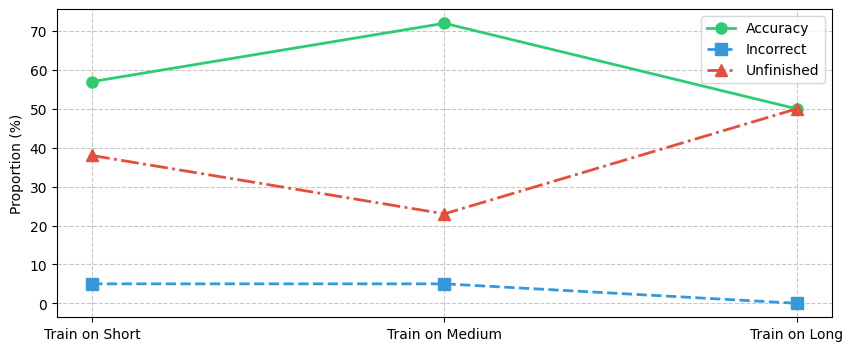

In [19]:
# 生成示例数据 (3,5)
data = np.array([
    short_metric,
    medium_metric,
    long_metric
]).T * 100

labels = ['Accuracy', 'Incorrect', 'Unfinished']
colors = ['#2ecc71', '#3498db', '#e74c3c']

fig = plot_multi_lines(data, labels, colors)
plt.savefig('./fig/accuracy_of_result.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 消融实验

In [30]:
with open('../results/format_v1.json', 'r') as f:
    format_v1 = json.load(f)
with open('../results/format_v2.json', 'r') as f:
    format_v2 = json.load(f)
with open('../results/format_v3.json', 'r') as f:
    format_v3 = json.load(f)

In [31]:
format_v1_metric = evaluate_result(format_v1)
format_v2_metric = evaluate_result(format_v2)
format_v3_metric = evaluate_result(format_v3)

In [32]:
format_v1_metric, format_v2_metric,format_v3_metric

((0.66, 0.09, 0.25), (0.84, 0.02, 0.14), (0.74, 0.01, 0.25))

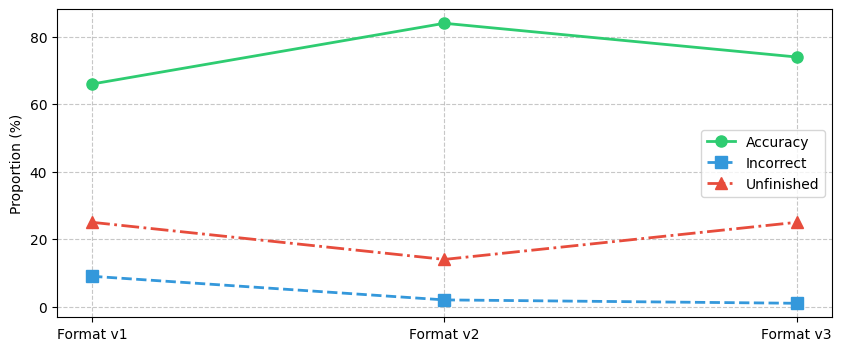

In [34]:
data = np.array([
    format_v1_metric,
    format_v2_metric,
    format_v3_metric,
]).T * 100

labels = ['Accuracy', 'Incorrect', 'Unfinished']
colors = ['#2ecc71', '#3498db', '#e74c3c']

fig = plot_multi_lines(data, labels, colors, x=["Format v1", "Format v2", "Format v3"])
plt.savefig('./fig/format_result.pdf', format='pdf', bbox_inches='tight')
plt.show()